In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Libraries

In [2]:
import os
import glob
import zipfile
import shapefile
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

# Necessary functions

In [3]:
data_dir = os.path.join(os.getcwd(),"data")
os.chdir(data_dir)

In [4]:
def get_lat_lon(sf, field, shape_dict):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shape_dict[field]]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
        data = pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])
    return data

def compute_statistics(column):
    stats = {}
    if column.dtype == 'float64':
        stats['mean'] = column.mean()
        stats['stddev'] = column.std()
        stats['min'] = column.min()
        stats['max'] = column.max()
        stats['q1'] = column.quantile(0.25)
        stats['q3'] = column.quantile(0.75)
    return stats

def compute_frequency(column):
    tab = column.groupby(column).agg('count')
    return tab

In [5]:
def color_bar(heat):
    if len(heat) !=0:
        norm = matplotlib.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    return cm, norm

In [6]:
def get_boundaries(shapefile):
    lat, lon = [], []
    for shape in list(shapefile.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [7]:
def colors_plot(heat, loc_id, continent, cm, norm):
    if len(heat) == 0:
        col = continent
    else:
        if loc_id not in heat:
            R,G,B,A = cm(norm(0))
        else:
            R,G,B,A = cm(norm(heat[loc_id]))
        col = [R,G,B]
    return col

In [8]:
def shapefile_part(shape, col):
    # check number of parts
    nparts = len(shape.parts)
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
        ax.add_patch(patch)
    # loop over parts of each shape, plot separately
    else:
        for ip in range(nparts): # loop over parts, plot separately
            i0 = shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)

In [9]:
def plot_map(ax, shapefile, field_id, field_zone, shape_dict,  heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    cm, norm = color_bar(heat)
    
    # iterate through every feature
    for sr in shapefile.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shape_dict[field_id]]
        zone = rec[shape_dict[field_zone]]
        
        # define color palette
        col = colors_plot(heat, loc_id, continent, cm, norm)
        
        # define colors for features
        shapefile_part(shape, col)
        
        
        # locate text
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shape_dict['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(shapefile)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

# 1. Data exploration and cleaning

## 1.1. Data loading

In [10]:
# Trip record data
# Find csv files
csv_files = [i for i in glob.glob('*.{}'.format('csv'))]
csv_files
# combine all csv files
all_csv_files = pd.concat([pd.read_csv(f) for f in csv_files])
# export to csv
all_csv_files.to_csv("taxi_data.csv", index=False, encoding='utf-8-sig')
# read compiled data
taxi_df = pd.read_csv("taxi_data.csv")

In [11]:
# Visualize data
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


In [12]:
# Location data

# Uncompress data
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")
# Load data as shp
taxi_zones = shapefile.Reader("shape/taxi_zones.shp")
# Get shp attributes
fields_name = [field[0] for field in taxi_zones.fields[1:]]
# Transform attributes to dict
taxi_zones_dict = dict(zip(fields_name, list(range(len(fields_name)))))
# Record attributes
attributes = taxi_zones.records()
# Transform data to list
taxi_zones_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [13]:
# Create data frame
df_loc = pd.DataFrame(taxi_zones_attr).join(get_lat_lon(taxi_zones, 'LocationID', taxi_zones_dict).set_index("LocationID"), on="LocationID")
# Visualize data
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


## 1.2. Data structure

In [14]:
## number of records
print('Records: ' + str(len(taxi_df)))
## number of colums
print('Columns: ' + str(len(taxi_df.columns)))

Records: 29236424
Columns: 17


In [15]:
## Columns names and types
taxi_df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

## 1.3. Data exploration

### 1.3.1. Missing values

In [16]:
## Missing values
taxi_df.columns[taxi_df.isnull().any()]  # Data has no missing values

Index([], dtype='object')

### 1.3.2. Basic Statistics

In [17]:
### Variables basic statistics
taxi_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07,2.923642e+07
mean,1.545904e+00,1.617798e+00,2.919386e+00,1.043350e+00,1.632024e+02,1.611910e+02,1.329500e+00,1.310930e+01,3.339407e-01,4.973104e-01,1.874055e+00,3.290113e-01,2.996283e-01,1.644710e+01
std,4.978884e-01,1.260992e+00,4.476535e+00,5.095108e-01,6.661417e+01,7.047819e+01,4.903471e-01,1.472817e+02,4.615744e-01,7.081708e-02,2.645570e+00,1.968881e+00,1.408904e-02,1.475248e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.500000e+02,-5.371000e+01,-5.000000e-01,-1.120000e+02,-1.750000e+01,-3.000000e-01,-5.503000e+02
25%,1.000000e+00,1.000000e+00,9.700000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.750000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.180000e+01
75%,2.000000e+00,2.000000e+00,3.010000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.450000e+01,5.000000e-01,5.000000e-01,2.460000e+00,0.000000e+00,3.000000e-01,1.780000e+01
max,2.000000e+00,1.920000e+02,9.496980e+03,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,6.304618e+05,6.980000e+01,1.400000e+02,4.500000e+02,1.018950e+03,1.000000e+00,6.304631e+05


### 1.3.3. Basic Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D1C4A8E80>,
      dtype=object)

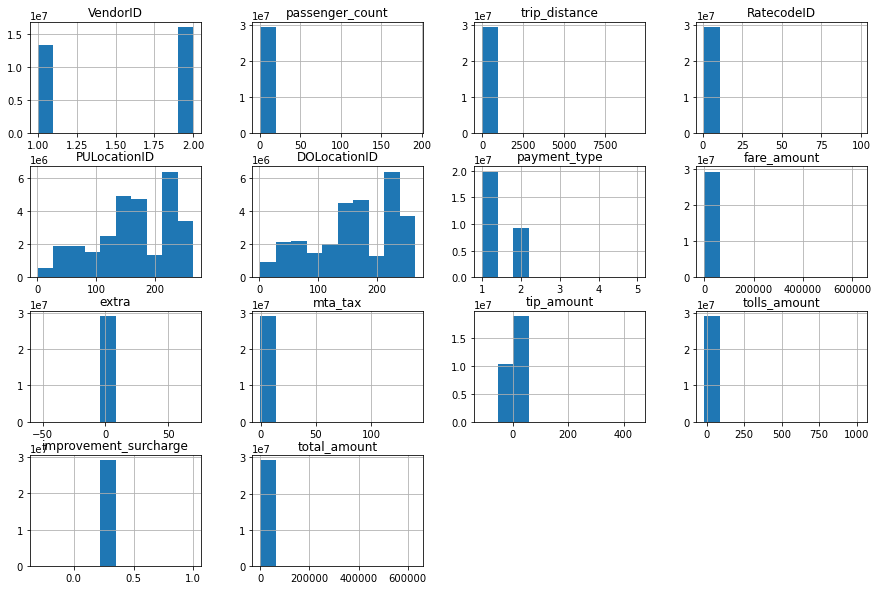

In [18]:
# Plot variables histograms
taxi_df.hist(figsize=(15, 10))

The histograms show that most of the variables present outliers and unreasonable values; variables such as total amount, fare amount and extra present negative and excessive values.  We must clean these factors if we want to consider them as candidates for modelling the tip amount.


Let's screen and clean these variables.


## 1.4. Data Cleaning

### 1.4.1. VendorID
A categorical variable indicating the LPEP provider that provided the record (Creative or VeriFone)

In [19]:
# Compute frequencies
compute_frequency(taxi_df['VendorID'])

VendorID
1    13276147
2    15960277
Name: VendorID, dtype: int64

The proportion between the two vendors is pretty similar. This variable does not look like a critical predictor to model the tip amount.

### 1.4.2. tpep_pickup_datetime
A time variable with the date and time when the meter was engaged.

In [20]:
# Tranform to datetime
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# Check years consistency
taxi_df.groupby(taxi_df['tpep_pickup_datetime'].map(lambda x: x.year)).count()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,,
2001,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2008,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2009,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
2017,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395,29236395
2041,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


The data contains records out of our study period. Let's remove this values.

In [22]:
# Remove incorrect data (observations with dates outside the study period mar-july-nov 2017)
taxi_df = taxi_df[(taxi_df['tpep_pickup_datetime'].dt.month.isin([3, 7, 11])) & (taxi_df['tpep_pickup_datetime'].dt.year == 2017)]

### 1.4.3. tpep_dropoff_datetime
A time variable with the date and time when the meter was disengaged. 

As happened with the 'tpep_pickup_datetime variable',  we will remove the record from years different to 2007. However, we will preserve records from other months since pickups from late nights at the end of March, July and November can lead to drop-offs in April, August and December.

In [23]:
# Tranform to datetime
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# Remove incorrect data (observations with dates outside the study period 2017)
taxi_df = taxi_df[taxi_df['tpep_dropoff_datetime'].dt.year == 2017]

### 1.4.4. Passenger Count

This variable represents the number of passengers per trip. 

Since it is a  driver-entered value, it is expected to be suceptible to errors.

In [24]:
## Calculate frequency
freq_pass = compute_frequency(taxi_df['passenger_count'])
freq_pass

passenger_count
0         51212
1      14028801
2       2834484
3        798930
4        370742
5        932066
6        562708
7            62
8            58
9            46
192           1
Name: passenger_count, dtype: int64

In [25]:
# Calculate percentage of zero passengers
zero_pas = (51213/len(taxi_df))*100
zero_pas

0.2615696014783103

Most of the values for the passenger_count variable are realistic. However, there is an observation with a passenger count of 192. This value is doubtful for a cap.  Likewise, there are trips with 0 passengers. We will remove the observations with 192 and 0 passengers since they represent only 0.26% of the data and can cause potential troubles when modelling the tip_amount.

In [26]:
# Remove passenger count outliers (0 and 192)
taxi_df = taxi_df[(taxi_df['passenger_count'] > 0.0) & (taxi_df['passenger_count'] < 192.0)]

In [27]:
## Calculate frequency again
freq_pass = compute_frequency(taxi_df['passenger_count'])
freq_pass

passenger_count
1    14028801
2     2834484
3      798930
4      370742
5      932066
6      562708
7          62
8          58
9          46
Name: passenger_count, dtype: int64

We can see that the number of passenger values is more consistent. Most of the trips have 1 or 2 passengers.  Trips with more than six passengers are less often.

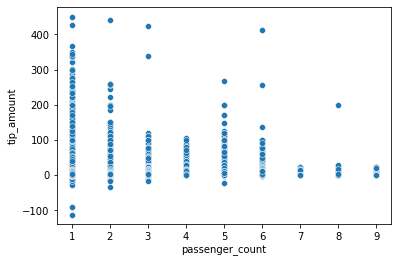

In [28]:
# Plot scatterplot
sns.scatterplot(x = taxi_df['passenger_count'],  y= taxi_df['tip_amount'])

There is not an evident relationship between the number of passengers and the tips. However, it looks like the fewer passengers there are, the more occasional tips are given.

### 1.4.5. trip_distance
The elapsed trip distance in miles reported by the taximeter.

In [29]:
# Compute statistics
trip_stats = compute_statistics(taxi_df['trip_distance'])
trip_stats

{'mean': 2.890716076596029,
 'stddev': 3.7248809383448673,
 'min': 0.0,
 'max': 702.5,
 'q1': 0.96,
 'q3': 3.0}

Distances of 0 and 702.5 miles? They are not realistic. The longest distance in New York City is around 40 miles. Considering the network structure, we can assume that the longest distance from two points using the road network is about 100 miles.

Let's investigate more

In [30]:
# Calculate trip duration
taxi_df['duration'] = (taxi_df['tpep_dropoff_datetime'] - taxi_df['tpep_pickup_datetime']).dt.total_seconds()

In [31]:
# Select record with a distance of 0
stats_zero = compute_statistics(taxi_df['duration'][taxi_df['trip_distance'] == 0])
stats_zero

{'mean': 240.05564839572193,
 'stddev': 3235.8959601662314,
 'min': -3564.0,
 'max': 86399.0,
 'q1': 4.0,
 'q3': 46.0}

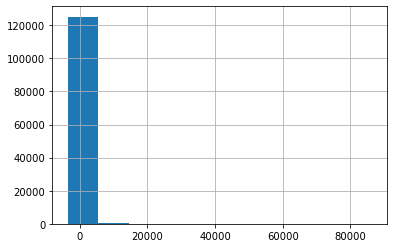

In [32]:
#Plot hist of duration
taxi_df['duration'][taxi_df['trip_distance'] == 0].hist()

The data seems to have errors. A zero-mile trip cannot have negative seconds or last for almost one day (86399 seconds = 23h).

We will remove these extreme values to clean and ensure data consistency.


In [33]:
# Remove trips with negative duration
taxi_df = taxi_df[taxi_df['duration'] > 0]

In [34]:
# Remove trips with excesive time trips for 0 distances (we chose a threshold of 7500 seconds)
taxi_df.drop(taxi_df[(taxi_df['trip_distance'] == 0) & (taxi_df['duration'] > 7500)].index, inplace=True)

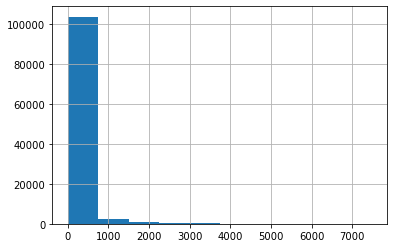

In [35]:
# Plot hist of duration
taxi_df['duration'][taxi_df['trip_distance'] == 0].hist()

In [36]:
# Select record with a distance greater than 100 miles
stats_greater_100 = compute_statistics(taxi_df['duration'][taxi_df['trip_distance'] > 100])
stats_greater_100

{'mean': 11871.615384615385,
 'stddev': 6682.31808186423,
 'min': 19.0,
 'max': 35028.0,
 'q1': 8011.250000000001,
 'q3': 15399.000000000002}

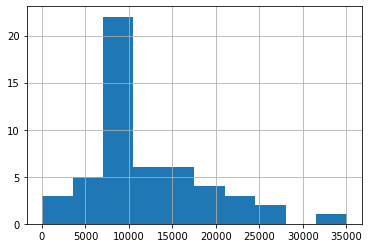

In [37]:
# Plot hist of trip distances greater than 100 miles
taxi_df['duration'][taxi_df['trip_distance'] > 100].hist()

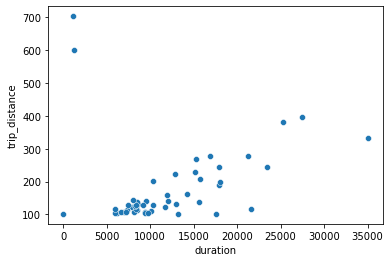

In [38]:
# Plot scatter plot of duration and distances for record with distances greater than 100 miles
taxi_greater_100 = taxi_df[['duration','trip_distance']][taxi_df['trip_distance'] > 100]
sns.scatterplot(x = taxi_greater_100['duration'],  y= taxi_greater_100['trip_distance'])

It looks like the distances greater than 500 miles are outliers. One would expect a linear relationship between the duration of the trip and its length.

Albeit some outlier could exist due to particular situations (traffic jams, multiple stops), we will remove it since they do not provide any information.


In [39]:
# Remove distances greater than 500 miles
taxi_df = taxi_df[taxi_df['trip_distance'] <= 500]

In [40]:
# Compute statistics
stats_trips = compute_statistics(taxi_df['trip_distance'])
stats_trips

{'mean': 2.8930708297299614,
 'stddev': 3.718146707172345,
 'min': 0.0,
 'max': 396.3,
 'q1': 0.96,
 'q3': 3.0}

The mean trip distance is 2.9 miles. 
Most trips are between 1.6  and 3.7 miles. These value will be relevant for modelling the tip prices.

### 1.4.6. PULocationID & DOLocationID
PULocationID TLC Taxi Zone in which the taximeter was engaged and disengaged.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D1C1F72E8>,
      dtype=object)

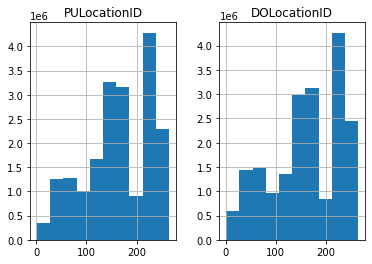

In [41]:
# Plot PULocationID
taxi_df[['PULocationID', 'DOLocationID']].hist()

We can see that the zones where pickups occur are very similar to those of the drop-offs.

Let's confirm.


In [42]:
# Create frequencies
freq_pu = pd.DataFrame({'count' : taxi_df.groupby(['PULocationID']).size()}).reset_index()
freq_do = pd.DataFrame({'count' : taxi_df.groupby(['DOLocationID']).size()}).reset_index()

# Merge with location shapefile
pu_loc_df = freq_pu.merge(df_loc, left_on="PULocationID", right_on="LocationID")
do_loc_df = freq_do.merge(df_loc, left_on="DOLocationID", right_on="LocationID")

In [43]:
# Select top 3 origin locations
pu_top_3 = pu_loc_df.sort_values(by=['count'], ascending=False).set_index("PULocationID").head(3)
pu_top_3

,count,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
PULocationID,,,,,,,,,
237,777009,237,0.042213,0.000096,Upper East Side South,237,Manhattan,993768.783313,219305.448647
161,736276,161,0.035804,0.000072,Midtown Center,161,Manhattan,990433.407940,215448.355221
236,707623,236,0.044252,0.000103,Upper East Side North,236,Manhattan,996155.897922,223614.973989


In [44]:
# Select top 3 distination locations
do_top_3 = do_loc_df.sort_values(by=['count'], ascending=False).set_index("DOLocationID").head(3)
do_top_3

,count,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
DOLocationID,,,,,,,,,
236,737705,236,0.044252,0.000103,Upper East Side North,236,Manhattan,996155.897922,223614.973989
161,716308,161,0.035804,0.000072,Midtown Center,161,Manhattan,990433.407940,215448.355221
237,682206,237,0.042213,0.000096,Upper East Side South,237,Manhattan,993768.783313,219305.448647


Yes, indeed, the locations are very similar. This means that some areas have high demands for yellow caps. The origin and destination places are located in the business areas in NY, mainly in Manhattan. 

In [45]:
# Create dict of the origin and destination counts
dict_pu = dict(zip(pu_loc_df['PULocationID'].tolist(), pu_loc_df['count'].tolist()))
dict_do = dict(zip(do_loc_df['DOLocationID'].tolist(), do_loc_df['count'].tolist()))

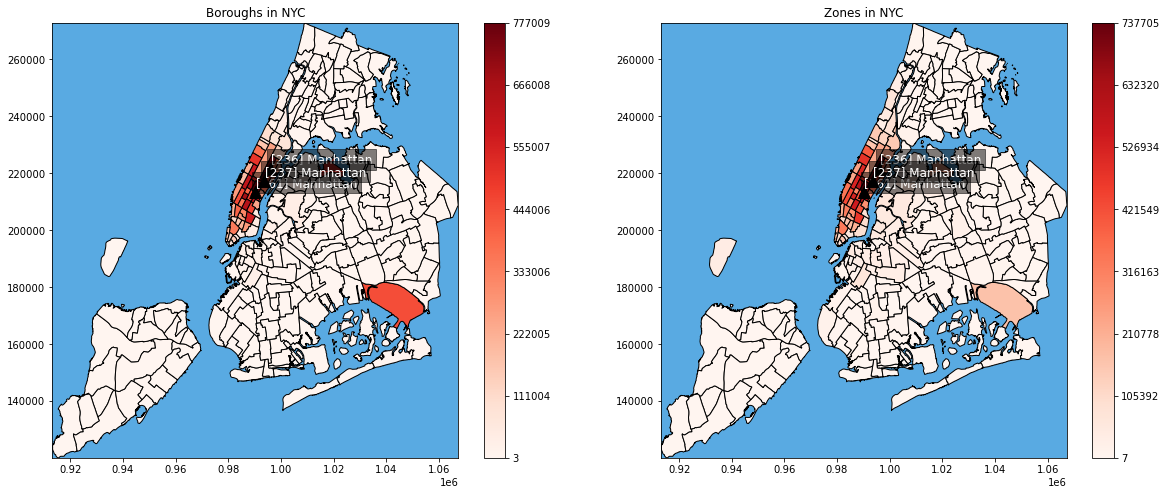

In [46]:
# Plot a map of the origin and destination counts

#Define subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)

# Plot maps
ax.set_title("Zones with most pickups")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_pu, text= pu_top_3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
plot_map(ax, taxi_zones, 'LocationID', 'borough', taxi_zones_dict, heat = dict_do, text= do_top_3.index.tolist())

Most of the trips start and end in **Manhattan**, where restaurants and entertainment venues are typical. Furthermore, we can see that also many trips start and end in the **JFK airport** zone in Queens. This situation is not surprising given the number of tourists that visit NY every year.

In [47]:
# Check JFK Airport counts
pu_loc_df['count'][pu_loc_df['zone'] == 'JFK Airport']

128    446378
Name: count, dtype: int64

We will not remove any record from the pickup and drop off variable since they do not have errors.

### 1.4.7. RateCodeID
The final rate code in effect at the end of the trip.

In [48]:
# Calculate frequencies
freq_rate = compute_frequency(taxi_df['RatecodeID'])
freq_rate

RatecodeID
1     18966545
2       428891
3        40193
4        10032
5        61714
6          142
99          12
Name: RatecodeID, dtype: int64

The rate codes seem good. We will remove just the ones with the '99' classification. They are probably missing values

In [49]:
# Remove 99 classification
taxi_df = taxi_df[taxi_df['RatecodeID'] != 99]

### 1.4.8. Store_and_fwd_flag
This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.

In [50]:
# Calculate frequencies
freq_flag = compute_frequency(taxi_df['store_and_fwd_flag'])
freq_flag

store_and_fwd_flag
N    19416375
Y       91142
Name: store_and_fwd_flag, dtype: int64

Most trips were not stored in vehicle memory. 
We will remove no values from related to this variable.

### 1.4.9. Payment_type
A numeric code signifying how the passenger paid for the trip. 

In [51]:
# Calculate frequencies
freq_pay_type = compute_frequency(taxi_df['payment_type'])
freq_pay_type

payment_type
1    13292931
2     6085995
3      100625
4       27966
Name: payment_type, dtype: int64

There is no unknown payment types (class 5) or void ones (class 6).
We will preseverve all the records for this variable.

### 1.4.10. Payment_type

The time-and-distance fare calculated by the meter.

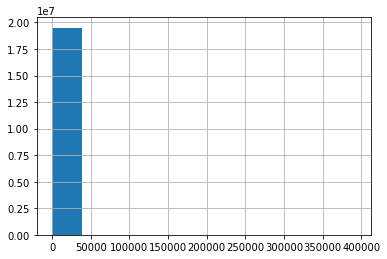

In [52]:
#Plot histogram
taxi_df['fare_amount'].hist()

In [53]:
# Compute statistics
stats_fare = compute_statistics(taxi_df['fare_amount'])
stats_fare

{'mean': 13.019691780866609,
 'stddev': 97.92441349426811,
 'min': -499.0,
 'max': 393221.5,
 'q1': 6.5,
 'q3': 14.5}

Negative fare amounts? These values are noise and must be removed. Likewise, a fare amount of 393221.5 does not appear realistic.

In [54]:
# Remove negative values
taxi_df = taxi_df[taxi_df['fare_amount'] > 0]

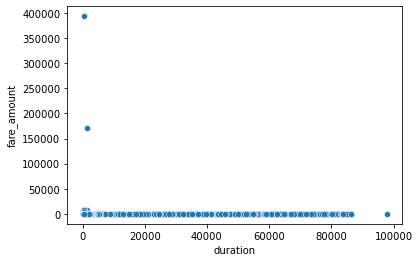

In [55]:
# Plot scatter plot between duration and fare amount
sns.scatterplot(x = taxi_df['duration'],  y= taxi_df['fare_amount'])

It seems that values greater than 50000 are outliers. The fare amount is computed based on the time of the trip, and thus, we will expect a linear relationship.

In [56]:
# Remove values greater than 50000
taxi_df = taxi_df[taxi_df['fare_amount'] < 50000]

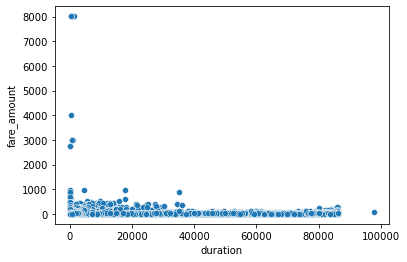

In [57]:
# Plot scatter plot between duration and fare amount again
sns.scatterplot(x = taxi_df['duration'],  y= taxi_df['fare_amount'])

We still have some outliers, let's remove them

In [58]:
# Remove values greater than 2000
taxi_df = taxi_df[taxi_df['fare_amount'] < 2000]

### 1.4.11. Extra

Miscellaneous extras and surchages. Currently, this only includes the 0.50 and 1 rush hour and overnight charges

In [59]:
stats_extra = compute_statistics(taxi_df['extra'])
stats_extra

{'mean': 0.3307859145919602,
 'stddev': 0.4600284250477714,
 'min': -42.5,
 'max': 69.8,
 'q1': 0.0,
 'q3': 0.5}

In [60]:
# Calculate values with extra greater than 5.0
len(taxi_df[taxi_df['extra'] >= 5])

29

There are some incorrect values. This variable is supposed to take only two values, 0.50 and 1.0. However, we will preserve vales up to 5.0. Values after 5.0 are very scarce and probably are noise.

In [61]:
# Remove values smaller than 0 and grater than 5
taxi_df = taxi_df[(taxi_df['extra'] >= 0) & (taxi_df['extra'] <= 5)]

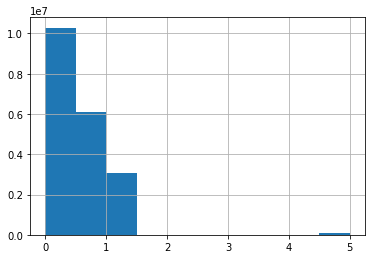

In [62]:
# Plot histogram
taxi_df['extra'].hist()

### 1.4.12. MTA_tax
0.50 MTA tax that is automatically triggered based on the metered
rate in use.

In [63]:
# Calculate statistics
stats_mta = compute_statistics(taxi_df['mta_tax'])
stats_mta

{'mean': 0.4979510470429189,
 'stddev': 0.03224914362856111,
 'min': 0.0,
 'max': 7.68,
 'q1': 0.5,
 'q3': 0.5}

First and third quantile suggest the presence of some outliers.

Let's remove them.

In [64]:
# Remove values smaller than 0.5
taxi_df = taxi_df[taxi_df['mta_tax'] <= 0.5]

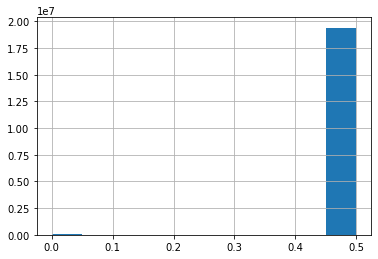

In [65]:
# Plot histogram
taxi_df['mta_tax'].hist()

### 1.4.13. Improvement_surchage
0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2015.

In [66]:
# Calculate statistics
stats_imp = compute_statistics(taxi_df['improvement_surcharge'])
stats_imp

{'mean': 0.2999791747968689,
 'stddev': 0.002501855100292935,
 'min': 0.0,
 'max': 0.55,
 'q1': 0.3,
 'q3': 0.3}

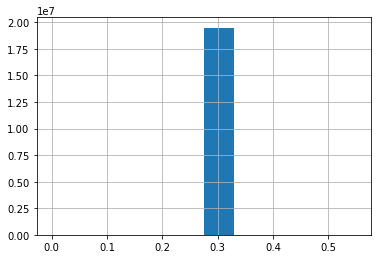

In [67]:
# Plot histogram
taxi_df['improvement_surcharge'].hist()

This variable was implemented to finance wheel-chair friendly vehicles. It will not probably influence the tip amount.
We will preserve it since it does not exhibit potential errors.

### 1.4.14. Tip_amount
Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.

In [68]:
# Calculate statistics
stats_tip = compute_statistics(taxi_df['tip_amount'])
stats_tip

{'mean': 1.874268576678008,
 'stddev': 2.6067339520248023,
 'min': -0.08,
 'max': 450.0,
 'q1': 0.0,
 'q3': 2.46}

We can see some outliers: negative tips and excesive tips.

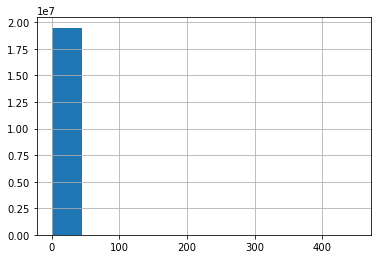

In [69]:
# Plot histogram
taxi_df['tip_amount'].hist()

In [70]:
# Remove negative values
taxi_df = taxi_df[taxi_df['tip_amount'] >= 0.0]

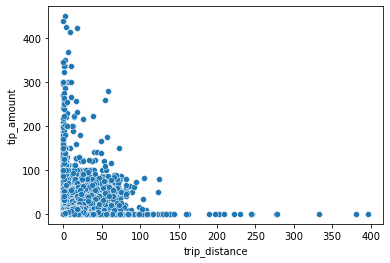

In [71]:
# Plot tips vs distance
sns.scatterplot(x = taxi_df['trip_distance'],  y= taxi_df['tip_amount'])

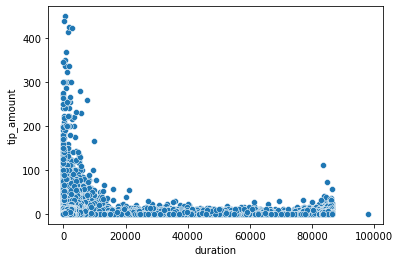

In [72]:
# Plot tips vs time
sns.scatterplot(x = taxi_df['duration'],  y= taxi_df['tip_amount'])

It looks like the tips have no direct relationship with the distance or duration of the trip. There must be other factors influencing the tip_mount variable. Perhaps, individual characteristics related to the passenger.

In [73]:
# check payment type for tip amounts
taxi_df['tip_amount'].groupby(taxi_df['payment_type']).count()

payment_type
1    13291408
2     6084252
3       92722
4       24925
Name: tip_amount, dtype: int64

We can see cash transactions are limited to credit card transactions.
This phenomenon strongly suggests that if it is a cash transaction, there will not be a tip. 
This is a significant characteristic.


In [74]:
# Remove other payment methods that do not provide tips. 
taxi_df = taxi_df[taxi_df['payment_type'] == 1]

Tips greater than 100 can occur. It depends on the passenger generosity. However, if we want to predict a sensible tip, we must remove these outliers. A regular passenger would not be willing to pay 200 dollars for a trip within NYC, at least not in standard settings.

In [82]:
# Remove high tips
taxi_df = taxi_df[taxi_df['tip_amount'] <= 200]

### 1.4.15. Tolls_amount
Total amount of all tolls paid in trip. 

In [85]:
# Compute stats
stats_toll = compute_statistics(taxi_df['tolls_amount'])
stats_toll

{'mean': 0.370723604007319,
 'stddev': 1.5800948774747894,
 'min': 0.0,
 'max': 172.8,
 'q1': 0.0,
 'q3': 0.0}

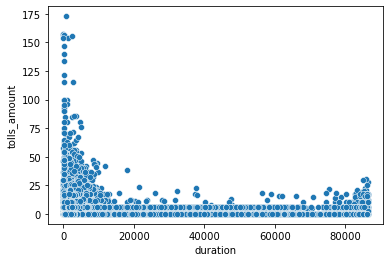

In [93]:
# Plot duration vs tolls amount
sns.scatterplot(x = taxi_df['duration'],  y= taxi_df['tolls_amount'])

We will preserve all the records since there is not clear outliers or noise.

### 1.4.16. Total_amount
The total amount charged to passengers. Does not include cash tips.

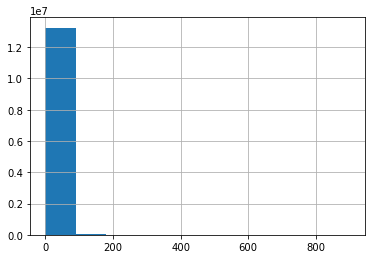

In [94]:
# Plot histogram
taxi_df['total_amount'].hist()

In [95]:
# Compute stats
stats_total = compute_statistics(taxi_df['total_amount'])
stats_total

{'mean': 17.76279543927481,
 'stddev': 14.94662694181196,
 'min': 0.31,
 'max': 900.0,
 'q1': 9.36,
 'q3': 19.55}

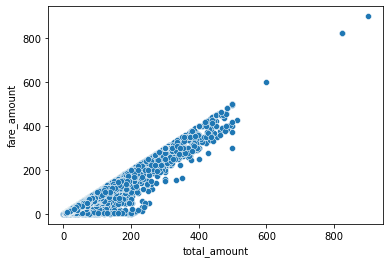

In [96]:
# Plot total amount vs fare_amount
sns.scatterplot(x = taxi_df['total_amount'],  y= taxi_df['fare_amount'])

It looks like the total amount is reasonable if we compare it to the fare amount. Let's explore the high values.

In [104]:
# Subset data greater than 550 dollars
taxi_df_550 = taxi_df[taxi_df['total_amount'] > 550]

In [105]:
# Visualize data
taxi_df_550

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
868769,2,2017-03-02 12:25:00,2017-03-02 12:26:00,1,0.0,5,N,264,264,1,825.0,0.0,0.0,0.0,0.0,0.0,825.0,60.0
8793677,2,2017-03-27 16:24:00,2017-03-27 16:25:00,1,0.0,5,N,264,264,1,600.0,0.0,0.0,0.0,0.0,0.0,600.0,60.0
20703985,2,2017-11-03 10:26:00,2017-11-03 10:27:00,1,0.0,5,N,264,264,1,825.0,0.0,0.0,0.0,0.0,0.0,825.0,60.0
21984900,2,2017-11-07 10:37:00,2017-11-07 10:38:00,1,0.0,5,N,264,264,1,900.0,0.0,0.0,0.0,0.0,0.0,900.0,60.0


It looks like these values are incorrect. In all of them, the trip duration is equal to one minute how a minute trip can cost more than 550 dollars.

Let's remove these outliers.

In [106]:
# Remove values greater than 550 dollars
taxi_df = taxi_df[taxi_df['total_amount'] < 550]

In [107]:
# Export cleaned data set
taxi_df.to_csv('taxi_data_cleaned.csv', index=False)

# Summary

We cleaned our data and removed all the potential errors in it. We also screen our variables superficially and found exciting insights into our data. For example, the region of Manhattan and the JKF airport comprise most of the origins and destinations of the yellow caps. These results highlight the importance of spatial analysis to understand the trips' dynamics and enrich the information.

Other findings point to possible candidates to predict the tip amount. Most of them are the variables with a direct relationship: the variables that involve a charge. Furthermore, we discovered that tips are only allowed in payments with credit cards; this reduced our dataset size dramatically. We also preserved many variables that we will probably not use in further analysis, but that can be useful to solve other questions.

Based on the upcoming data summary, we will create and derivate more variables to improve the prediction of the tip amount. For example, the time variables (pickups and drop-offs date-times) and trip distance do not provide much information by themselves. However, if we transform them into more explicit factors, such as a weekday or speed, our tip amount model will be nourished with better influencing covariates.